The whole notebook takes around **60 seconds** to complete on a machine with Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz.

In [2]:
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm

import peca

In [3]:
def exponential_ma_model(length, order):
    timeseries = np.random.exponential(size=length)
    if order > 1:
        timeseries = np.convolve(timeseries, [1./order] * order, mode="same")
        timeseries = (timeseries-timeseries.mean())/timeseries.std()
        timeseries = timeseries-timeseries.min()
    return timeseries

# Figure 4
Canonical trigger coincidence processes and corresponding QTR plot,
for a simulated time series and two event series (independent and dependent).

In [4]:
# random data or data from paper?
random_data = False

if random_data:
    length = 4096
    delta = 7
    n_events = 32
    order = 8
    shift = 4
    timeseries = exponential_ma_model(length, order)
    eventseries_ind = np.zeros(length)
    eventseries_ind[np.random.choice(range(length-delta),
                                     size=n_events,
                                     replace=False)] = 1
    eventseries_dep = np.zeros(length)
    eventseries_dep[np.random.choice(np.where(timeseries > 4)[0] - shift,
                                     size=n_events, replace=False)] = 1
else:
    # load data from the paper
    data = pd.read_csv("data/fig4.dat", sep=" ", index_col=0)
    timeseries = data["X"].values
    eventseries_ind = data["E"].values  # independent
    eventseries_dep = data["E_dep"].values  # dependent
    length = len(timeseries)
    n_events = eventseries_dep.sum()

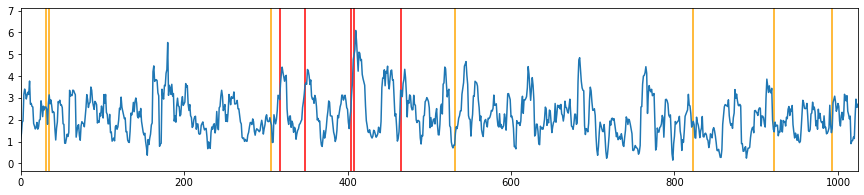

In [5]:
plt.figure(figsize=(15, 3))
for event in np.where(eventseries_ind == 1)[0]:
    plt.axvline(event, c="orange")
for event in np.where(eventseries_dep == 1)[0]:
    plt.axvline(event, c="red")
plt.plot(timeseries)
plt.xlim(0, 1024)
plt.show()

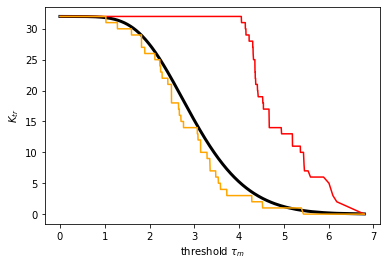

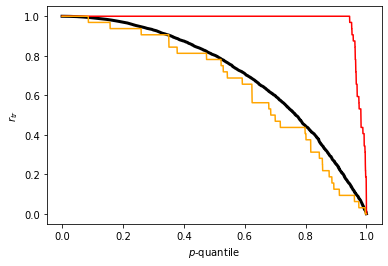

In [6]:
delta = 7
taus = np.sort(timeseries)  # for canonical process

tcp_params = peca.tcp_params_fit(timeseries, delta, taus)
tcp_ind = peca.tcp(timeseries, eventseries_ind, delta, taus)
tcp_dep = peca.tcp(timeseries, eventseries_dep, delta, taus)

plt.plot(taus, peca.tcp_marginal_expectation(n_events, tcp_params),
         c="black", lw=3)
plt.plot(taus, tcp_dep, c="red")
plt.plot(taus, tcp_ind, c="orange")
plt.xlabel("threshold $\\tau_m$")
plt.ylabel("$K_{tr}$")
plt.show()

plt.plot(np.linspace(1. / length, 1, length),
         peca.tcp_marginal_expectation(n_events, tcp_params) / n_events,
         c="black", lw=3)
plt.plot(np.linspace(1. / length, 1, length), tcp_dep / n_events, c="red")
plt.plot(np.linspace(1. / length, 1, length), tcp_ind / n_events, c="orange")
plt.xlabel("$p$-quantile")
plt.ylabel("$r_{tr}$")
plt.show()

# Figure 5
Expected QTR plots for simulated pairs of independent time series and event series, for three
different levels of serial dependencies (MA orders 0, 32, 128) and increasing time tolerance
($\Delta$ = 0, 1, 2, 4, 8, 16, 32, 64).

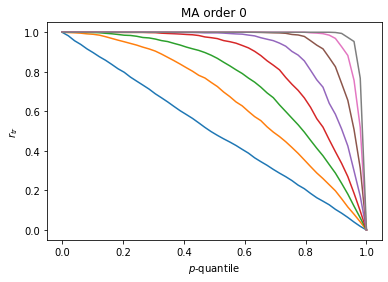

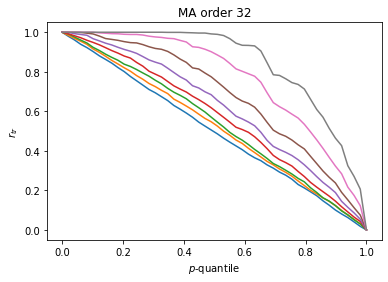

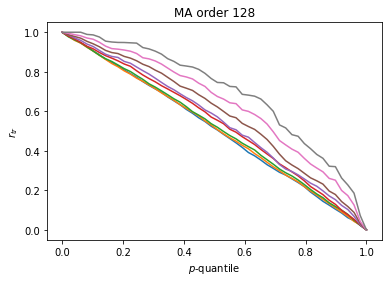

In [7]:
length = 4196
deltas = [0, 1, 2, 4, 8, 16, 32, 64]
rhos = np.linspace(0, 1, 50)
orders = [0, 32, 128]
n_events = 32
repetitions = 100

q_tr_vals = np.zeros((len(orders), len(deltas), len(rhos)))
for i, order in enumerate(orders):
    timeseries = exponential_ma_model(length, order)
    taus = np.percentile(timeseries, rhos * 100)
    for j, delta in enumerate(deltas):
        for rep in range(repetitions):
            eventseries = np.zeros(length)
            eventseries[np.random.choice(range(length-delta),
                                         size=n_events,
                                         replace=False)] = 1
            q_tr_vals[i, j, :] += (peca.tcp(timeseries, eventseries,
                                            delta, taus) / float(n_events))
        q_tr_vals[i, j, :] /= repetitions
        plt.plot(rhos, q_tr_vals[i, j, :])
        plt.title("MA order %d" % order)
        plt.xlabel("$p$-quantile")
        plt.ylabel("$r_{tr}$")
    plt.show()

# Figure 7
Comparison of null distributions (Monte Carlo, Bernoulli, GEV) of the number of trigger coincidences under independence, for three time series with different MA orders, at three thresholds ($\tau$ = 3, 4, 5).

In [8]:
def simulate(length, order, n_events, taus, deltas, samples):
    # success probabilities under GEV distribution (our work)
    p_gevs = np.empty((len(taus), len(deltas)))

    # success probabilities under Bernoulli assumption (previous work)
    p_bers = np.empty((len(taus), len(deltas)))

    timeseries = exponential_ma_model(length, order)
    tcps = np.zeros((len(taus), len(deltas), samples))
    for j, delta in enumerate(deltas):
        # estimate p under GEV distribution
        p_gevs[:, j] = peca.tcp_params_fit(timeseries, delta,
                                           np.array(taus))[0]

        for i, tau in enumerate(taus):
            # estimate p under Bernoulli assumption
            tes = (timeseries > tau) * 1  # threshold exceedance series
            n_exceedance = tes.sum()
            p_bers[i, j] = (1 - (1 - n_exceedance/length)**(delta + 1))

            # Monte Carlo estimate
            for s in tqdm(range(samples),
                          desc=f"delta={delta:0.2f} tau={tau:.2f}"):
                # sample independent event series
                eventseries = np.zeros(length)
                eventseries[np.random.choice(range(length-delta),
                                             size=n_events, replace=False)] = 1

                # record observed number of trigger coincidences
                tcps[i, j, s] = peca.tcp(timeseries, eventseries,
                                         delta, np.array([tau]))[0]

    return {
        "tcps" : tcps,
        "p_gevs" : p_gevs,
        "p_bers" : p_bers
    }

def plot_simulation(sim, i, j, samples, n_events):
    plt.plot(np.sort(sim["tcps"][i, j]),
             ((np.array(range(samples)) + 1) / samples),
             label="emp")
    plt.plot(np.linspace(0, n_events, 1000),
             stats.binom.cdf(np.linspace(0, n_events, 1000),
                             n_events, sim["p_bers"][i, j]),
             label="ber")
    plt.plot(np.linspace(0, n_events, 1000),
             stats.binom.cdf(np.linspace(0, n_events, 1000),
                             n_events, sim["p_gevs"][i, j]),
             label="gev")
    plt.xlim(0, n_events)
    plt.legend()

In [9]:
length = 8192
n_events = 32
taus = [5, 4, 3]
deltas = [7]
samples = 1000

np.random.seed(2)
sim_ma0 = simulate(length, 0, n_events, taus, deltas, samples)
sim_ma32 = simulate(length, 32, n_events, taus, deltas, samples)
sim_ma64 = simulate(length, 64, n_events, taus, deltas, samples)

delta=7.00 tau=3.00: 100%|██████████| 1000/1000 [00:00<00:00, 1162.50it/s]


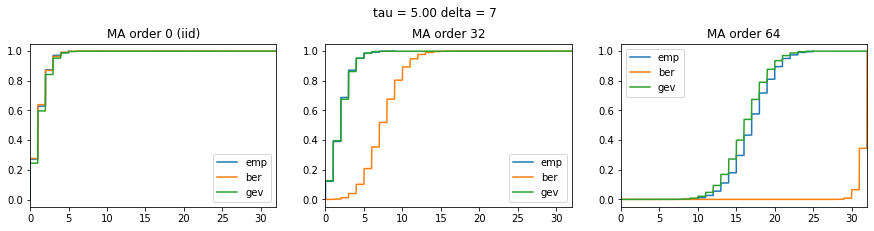

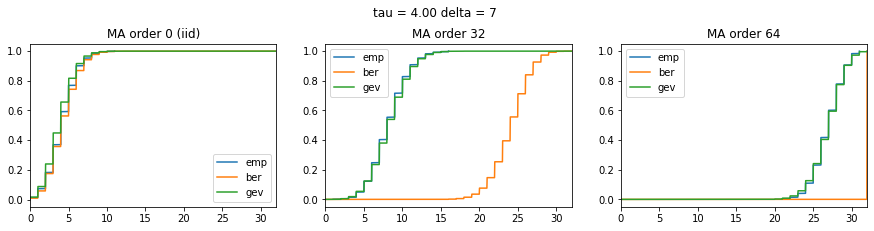

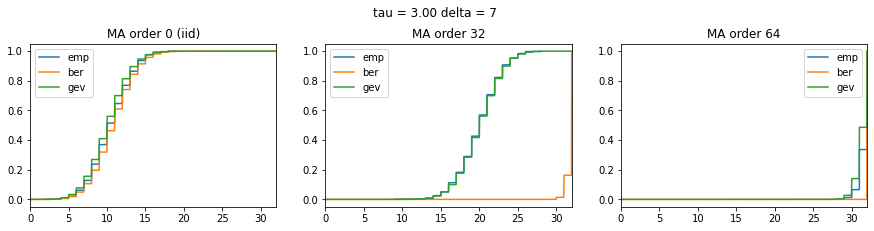

In [10]:
for i in range(len(taus)):
    for j in range(len(deltas)):
        plt.figure(figsize=(15, 3))
        plt.suptitle("tau = %.2f delta = %d" % (taus[i], deltas[j]), y=1.05)

        plt.subplot(131)
        plt.title("MA order 0 (iid)")
        plot_simulation(sim_ma0, i, j, samples, n_events)

        plt.subplot(132)
        plt.title("MA order 32")
        plot_simulation(sim_ma32, i, j, samples, n_events)

        plt.subplot(133)
        plt.title("MA order 64")
        plot_simulation(sim_ma64, i, j, samples, n_events)

        plt.show()

# Figure 9
Simulated trigger coincidence processes under independence, colorized by their
surprise value, along with the theoretical minima and maxima.

In [11]:
length = 8192
n_events = 32
order = 8
delta = 7
rhos = np.linspace(0.75, 1, 32)

timeseries = exponential_ma_model(length, order)
eventseries = np.zeros(length)
eventseries[np.random.choice(range(length-delta),
                             size=n_events, replace=False)] = 1

taus = np.percentile(timeseries, rhos * 100)
tcp_params = peca.tcp_params_fit(timeseries, delta, taus)

### Simulate trigger coincidence processes from independent event series

In [12]:
simuls = 1000
simul_nlls = np.zeros(simuls)
simul_tcps = np.zeros((simuls, len(rhos)))
for s in tqdm(range(simuls)):
    simul_eventseries = np.random.permutation(eventseries)
    simul_tcps[s, :] = peca.tcp(timeseries, simul_eventseries, delta, taus)
    simul_nlls[s] = peca.tcp_nll(simul_tcps[s, :], n_events, tcp_params)

100%|██████████| 1000/1000 [00:03<00:00, 295.27it/s]


### Compute most likely and least likely trigger coincidence process from Markov model
... which corresponds to the highest and lowest possible test statistic values

100%|██████████| 31/31 [00:03<00:00,  8.65it/s]


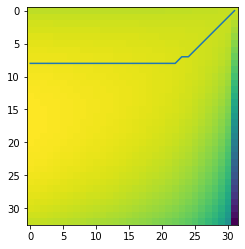

In [16]:
# find the most likely TCP with dynamic programming
qmax = (-np.infty) * np.ones((n_events + 1, len(rhos)))
qmax[:, 0] = [stats.binom.logpmf(k, n_events, tcp_params[0][0])
              for k in range(0, n_events + 1)]
qargmax = (-1) * np.ones((n_events + 1, len(rhos)), dtype="int")
for m in tqdm(range(1, len(rhos))):
    qmax[:, m] = [np.max([
        (qmax[kprev, m - 1] + stats.binom.logpmf(k, kprev, tcp_params[1][m]))
        for kprev in range(k, n_events + 1)])
                  for k in range(0, n_events + 1)]
    qargmax[:, m] = [k + np.argmax([
        (qmax[kprev, m - 1] + stats.binom.logpmf(k, kprev, tcp_params[1][m]))
        for kprev in range(k, n_events + 1)])
                     for k in range(0, n_events + 1)]

# backtracking to find the best path
mode = np.zeros_like(rhos) * np.nan
m = len(rhos) - 1
k = np.argmax(qmax[:, m])
while k >= 0:
    mode[m] = k
    k = qargmax[k, m]
    m = m - 1

# plot path through DP table
plt.imshow(qmax)
plt.plot(mode)
plt.show()

100%|██████████| 31/31 [00:03<00:00,  8.26it/s]


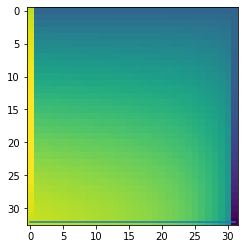

In [17]:
# find the least likely TCP with dynamic programming
qmin = np.infty * np.ones((n_events + 1, len(rhos)))
qmin[:, 0] = [stats.binom.logpmf(k, n_events, tcp_params[0][0])
              for k in range(0, n_events + 1)]
qargmin = (-1) * np.ones((n_events + 1, len(rhos)), dtype="int")
for m in tqdm(range(1, len(rhos))):
    qmin[:, m] = [np.min([
        (qmin[kprev, m - 1] + stats.binom.logpmf(k, kprev, tcp_params[1][m]))
        for kprev in range(k, n_events + 1)])
                  for k in range(0, n_events + 1)]
    qargmin[:, m] = [k + np.argmin([
        (qmin[kprev, m-1] + stats.binom.logpmf(k, kprev, tcp_params[1][m]))
        for kprev in range(k, n_events + 1)])
                     for k in range(0, n_events + 1)]

# backtracking to find the worst path
antimode = np.zeros_like(rhos) * np.nan
m = len(rhos) - 1
k = np.argmin(qmin[:, m])
while k >= 0:
    antimode[m] = k
    k = qargmin[k, m]
    m = m - 1

# plot path through DP table
plt.imshow(qmin)
plt.plot(antimode)
plt.show()

### Plot everything

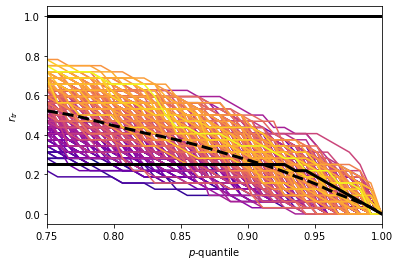

In [18]:
cmap = plt.get_cmap("plasma")

simul_tcps_sorted = simul_tcps[np.argsort(simul_nlls)].copy()
simul_nlls_sorted = simul_nlls.copy()
simul_nlls_sorted.sort()

for tcp, nll in zip(simul_tcps_sorted, simul_nlls_sorted):
    color = ((nll - simul_nlls_sorted[0])
             / (simul_nlls_sorted[-1] - simul_nlls_sorted[0]))
    plt.plot(rhos, tcp/n_events, color=cmap(color), alpha=1)

plt.plot(rhos, mode/n_events, "k-", lw=3, alpha=1)
plt.plot(rhos, antimode/n_events, "k-", lw=3, alpha=1)
plt.plot(rhos, peca.tcp_marginal_expectation(n_events, tcp_params) / n_events,
         "k--", lw=3, alpha=1)
plt.xlabel("$p$-quantile")
plt.ylabel("$r_{tr}$")
plt.xlim((rhos[0], 1))
plt.show()